In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
%%bash
kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown



100%|██████████| 312M/312M [00:00<00:00, 648MB/s]


In [3]:
!unzip brain-tumor-segmentation.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         

In [4]:
!pip install opencv-python scikit-image tqdm


In [5]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_otsu, threshold_sauvola
from tqdm import tqdm


In [6]:
def dice_score(pred, true):
    pred = pred.astype(bool)
    true = true.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    return 2. * intersection / (pred.sum() + true.sum() + 1e-8)

def jaccard_score(pred, true):
    pred = pred.astype(bool)
    true = true.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / (union + 1e-8)


In [7]:
def otsu_segmentation(image):
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary.astype(np.uint8)


In [8]:
def sauvola_segmentation(image):
    window_size = 51
    thresh = threshold_sauvola(image, window_size=window_size)
    binary = image > thresh
    return binary.astype(np.uint8)


In [11]:
image_dir = 'images'
mask_dir = 'masks'

otsu_dice_list = []
otsu_jaccard_list = []
sauvola_dice_list = []
sauvola_jaccard_list = []

for filename in tqdm(sorted(os.listdir(image_dir))):

    if not filename.endswith(".png"):
        continue

    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = (mask > 127).astype(np.uint8)

    # Skip empty masks
    if mask.sum() == 0:
        continue

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image)

    image = cv2.GaussianBlur(image, (5,5), 0)

    # Otsu
    otsu_pred = otsu_segmentation(image)

    # Sauvola
    sauvola_pred = sauvola_segmentation(image)


    otsu_dice_list.append(dice_score(otsu_pred, mask))
    otsu_jaccard_list.append(jaccard_score(otsu_pred, mask))

    sauvola_dice_list.append(dice_score(sauvola_pred, mask))
    sauvola_jaccard_list.append(jaccard_score(sauvola_pred, mask))

100%|██████████| 3064/3064 [01:46<00:00, 28.84it/s]


In [12]:
print("OTSU")
print("Average Dice:", np.mean(otsu_dice_list))
print("Average Jaccard:", np.mean(otsu_jaccard_list))

print("\nSAUVOLA")
print("Average Dice:", np.mean(sauvola_dice_list))
print("Average Jaccard:", np.mean(sauvola_jaccard_list))


OTSU
Average Dice: 0.06446810549436073
Average Jaccard: 0.034122180954287956

SAUVOLA
Average Dice: 0.03620090180653907
Average Jaccard: 0.01863306278840888


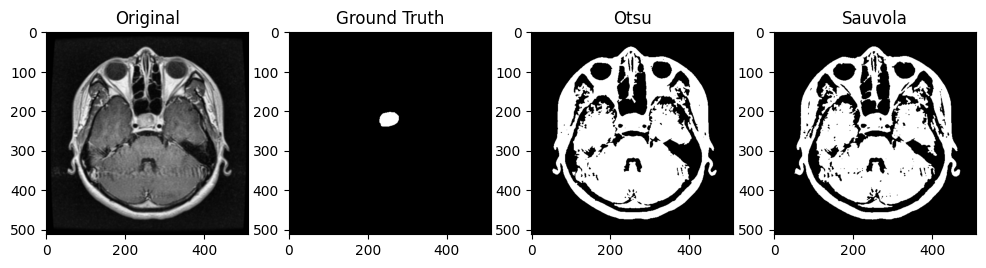

In [ ]:
import matplotlib.pyplot as plt

sample = filename  # last processed image

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(image, cmap='gray')

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask, cmap='gray')

plt.subplot(1,4,3)
plt.title("Otsu")
plt.imshow(otsu_pred, cmap='gray')

plt.subplot(1,4,4)
plt.title("Sauvola")
plt.imshow(sauvola_pred, cmap='gray')

plt.show()


## Reault:
Both Otsu and Sauvola gave very low overlap scores, which means they are not good enough for accurate brain tumor segmentation. Otsu performed a little better than Sauvola, but the overall results are still poor. This shows that simple thresholding methods are not suitable for this task, and more advanced techniques are needed to get reliable and accurate segmentation.